In [135]:
%pip install tqdm


[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [136]:
# Implementing a simple CNN using PyTorch and training it on the CIFAR-10 dataset
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import  transforms
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [137]:
# Configuring the device
device = torch.device('gpu' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


In [138]:
# Defining Hyperparameters
num_epochs = 5
batch_size = 5
learning_rate = 0.001

In [139]:
# Loading the CIFAR-10 dataset and creating the data loaders for training and testing

transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.RandomResizedCrop(32, scale=(0.8, 1.0)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # Adjust means and stds based on your dataset
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])


train_data = torchvision.datasets.CIFAR10(root = './data', train = True, download = True, transform=transform)
test_data = torchvision.datasets.CIFAR10(root = './data', train = False, download=True,transform=transform_test)

train_loader =  torch.utils.data.DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_data, batch_size=batch_size, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


In [140]:
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

In [141]:
dataiter = iter(train_loader)
images, labels = next(dataiter)

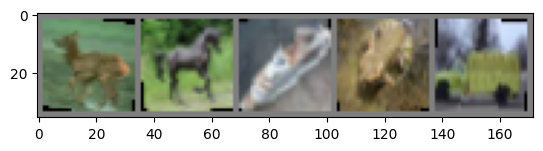

In [142]:
imshow(torchvision.utils.make_grid(images))

In [143]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.5)
        self.fc1 = nn.Linear(128 * 4 * 4, 256)
        self.fc2 = nn.Linear(256, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = x.view(-1, 128 * 4 * 4)  # Flatten the tensor
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.fc2(x)
        return x

In [144]:
model = ConvNet().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.RMSprop(model.parameters(), lr=learning_rate)

n_total_steps = len(train_loader)
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        # origin shape: [4, 3, 32, 32] = 4, 3, 1024
        # input_layer: 3 input channels, 6 output channels, 5 kernel size
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (i+1) % 1000 == 0:
            print (f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{n_total_steps}], Loss: {loss.item():.4f}')

Epoch [1/5], Step [1000/10000], Loss: 2.3949
Epoch [1/5], Step [2000/10000], Loss: 1.8507
Epoch [1/5], Step [3000/10000], Loss: 1.5139
Epoch [1/5], Step [4000/10000], Loss: 2.3737
Epoch [1/5], Step [5000/10000], Loss: 2.0858
Epoch [1/5], Step [6000/10000], Loss: 1.1472
Epoch [1/5], Step [7000/10000], Loss: 1.4780
Epoch [1/5], Step [8000/10000], Loss: 0.8442
Epoch [1/5], Step [9000/10000], Loss: 1.2628
Epoch [1/5], Step [10000/10000], Loss: 1.8276
Epoch [2/5], Step [1000/10000], Loss: 1.7554
Epoch [2/5], Step [2000/10000], Loss: 1.3462
Epoch [2/5], Step [3000/10000], Loss: 0.7883
Epoch [2/5], Step [4000/10000], Loss: 1.3716
Epoch [2/5], Step [5000/10000], Loss: 1.6689
Epoch [2/5], Step [6000/10000], Loss: 2.4264
Epoch [2/5], Step [7000/10000], Loss: 1.2183
Epoch [2/5], Step [8000/10000], Loss: 0.8575
Epoch [2/5], Step [9000/10000], Loss: 1.8518
Epoch [2/5], Step [10000/10000], Loss: 1.3603
Epoch [3/5], Step [1000/10000], Loss: 1.8601
Epoch [3/5], Step [2000/10000], Loss: 0.8458
Epoch [3

In [145]:
import os
os.makedirs('./Model', exist_ok=True)
model_dir = os.path.join('./Model')
save_model_path = './Model/cifar_convnet'
torch.save(model.state_dict(), save_model_path)

# TESTING

target_values = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

with torch.no_grad():
    n_correct = 0
    n_samples = 0
    n_class_correct = [0 for i in range(10)]
    n_class_samples = [0 for i in range(10)]
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        # max returns (value ,index)
        _, predicted = torch.max(outputs, 1)
        n_samples += labels.size(0)
        n_correct += (predicted == labels).sum().item()
        
        for i in range(batch_size):
            label = labels[i]
            pred = predicted[i]
            if (label == pred):
                n_class_correct[label] += 1
            n_class_samples[label] += 1

    acc = 100.0 * n_correct / n_samples
    print(f'Accuracy of the network: {acc} %')

    for i in range(10):
        acc = 100.0 * n_class_correct[i] / n_class_samples[i]
        print(f'Accuracy of {target_values[i]}: {acc} %')

Accuracy of the network: 60.12 %
Accuracy of plane: 68.6 %
Accuracy of car: 83.9 %
Accuracy of bird: 32.2 %
Accuracy of cat: 28.2 %
Accuracy of deer: 53.9 %
Accuracy of dog: 56.0 %
Accuracy of frog: 77.4 %
Accuracy of horse: 68.1 %
Accuracy of ship: 62.7 %
Accuracy of truck: 70.2 %
